In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import SVD,Reader,Dataset
from surprise.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df_c=pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
df_k=pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
df_l=pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')
df_m=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
df_r=pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv')

/tmp/ipykernel_42/3925749042.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_m=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


In [5]:
df_c.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [6]:
df_k.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
df_l.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
df_r.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [9]:
df_m.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [10]:
C= df_m['vote_average'].mean()
C

5.618207215134185

In [11]:
min_percent= df_m['vote_count'].quantile(0.9)
min_percent

160.0

In [12]:
q_movies = df_m.copy().loc[df_m['vote_count'] >= min_percent]
q_movies.shape

(4555, 24)

In [13]:
def weighted_rating(x, min_percent=min_percent, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # IMDB formula
    return (v/(v+min_percent) * R) + (min_percent/(min_percent+v) * C)

In [14]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)


In [15]:
q_movies = q_movies.sort_values('score', ascending=False)

In [16]:
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


In [17]:
non_numeric_popularity = df_m[~df_m['popularity'].apply(lambda x: isinstance(x, (int, float)))]['popularity']
print(non_numeric_popularity)


32768    0.837228
32769    7.350821
32770    0.244392
32771    0.215456
32772    1.208227
           ...   
45461    0.072051
45462    0.178241
45463    0.903007
45464    0.003503
45465    0.163015
Name: popularity, Length: 12697, dtype: object


In [18]:
df_m['popularity'] = pd.to_numeric(df_m['popularity'], errors='coerce')
df_m.dropna(subset=['popularity'], inplace=True)  # Drop rows with NaN in the 'popularity' column


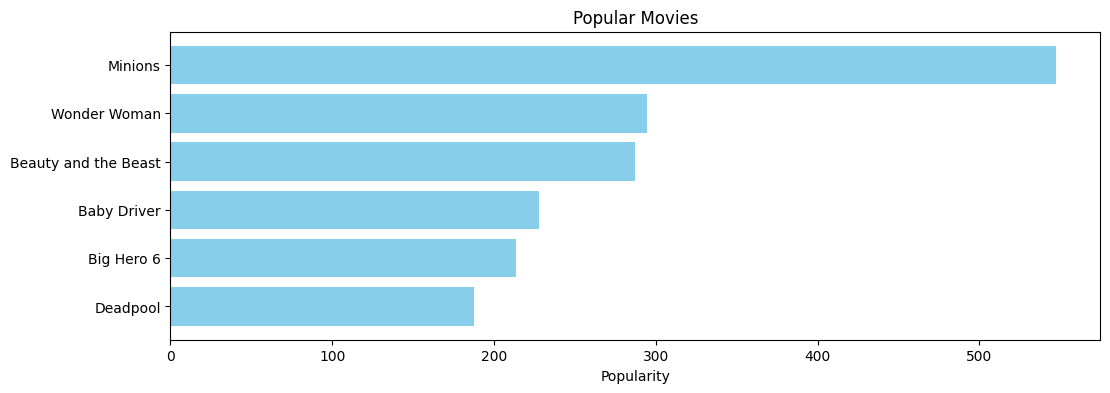

In [19]:
pop = df_m.sort_values('popularity', ascending=False)

plt.figure(figsize=(12, 4)) 
plt.barh(pop['title'].head(6), pop['popularity'].head(6), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")
plt.show()

Content based Filtering

In [20]:
df_m['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [21]:
tfidf = TfidfVectorizer(stop_words='english')

In [22]:
df_m['overview']=df_m['overview'].fillna('')

In [23]:
tfidf_matrix = tfidf.fit_transform(df_m['overview'])

In [24]:
tfidf_matrix.shape

(45460, 75827)

In [25]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [26]:
indices = pd.Series(df_m.index, index=df_m['title']).drop_duplicates()

In [27]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df_m['title'].iloc[movie_indices]

In [28]:
get_recommendations('The Dark Knight Rises')


1                         Jumanji
2                Grumpier Old Men
3               Waiting to Exhale
4     Father of the Bride Part II
5                            Heat
6                         Sabrina
7                    Tom and Huck
8                    Sudden Death
9                       GoldenEye
10         The American President
Name: title, dtype: object

Collaborative Filtering

In [29]:
reader = Reader()

In [30]:
df_r.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [31]:
data = Dataset.load_from_df(df_r[['userId', 'movieId', 'rating']], reader)
data = Dataset.load_from_df(df_r[['userId','movieId','rating']],reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x787c67396180>

In [32]:
trainset = data.build_full_trainset()

In [33]:
svd_model = SVD()

In [34]:
svd_model.fit(trainset)

In [37]:
df_r[df_r['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148
6,1,2762,4.5,1425941300
7,1,2918,5.0,1425941593
8,1,2959,4.0,1425941601
9,1,4226,4.0,1425942228


In [46]:
svd.predict(1, 302, 3)

NameError: name 'svd' is not defined